<a href="https://colab.research.google.com/github/fsarab/covid_fake_news/blob/main/COVID(FakeNews).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Fake News Detection

By : **Fatemeh Arab**

Course : Machine Learning (Final Project)

Professor : Dr. M.Akbari


---

The following article is mainly used.

Paper:
[https://arxiv.org/abs/2011.03327]

Data (train, validation, test, test labels): 
[https://competitions.codalab.org/competitions/26655] 

@misc{patwa2020fighting,

      title={Fighting an Infodemic: COVID-19 Fake News Dataset}, 
      author={Parth Patwa and Shivam Sharma and Srinivas PYKL and Vineeth Guptha and Gitanjali Kumari and Md Shad Akhtar and Asif Ekbal and Amitava Das and Tanmoy Chakraborty},
      year={2020},
      eprint={2011.03327},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}



## Import and Download Package

In [ ]:
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 KB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622381 sha256=28df2211f9c030a2082a44dceecd13189535994cf8f20adab89e7d21c4272b67
  Stored in directory: /root/.cache/pip/wheels/72/b8/3b/a90246d13090e85394a8a44b78c8abf577c0766f29d6543c75
Successfully built autocorrect


In [ ]:
## Base Libs 
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
import re
## ntlk 
import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk import sent_tokenize
## Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
## Others
from autocorrect import Speller
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [ ]:
## Download Packages we need from nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Read Files

In [ ]:
## Load Data file (.xlxs)
train = pd.read_excel('/content/Constraint_English_Train.xlsx',index_col='id')
val = pd.read_excel('/content/Constraint_English_Val.xlsx',index_col='id')
test=pd.read_excel('/content/Constraint_English_Test.xlsx',index_col='id')
test_withlabel=pd.read_excel('/content/english_test_with_labels.xlsx',index_col='id')

In [ ]:
## Display Train
train.head()

,tweet,label
id,,
1.0,The CDC currently reports 99031 deaths. In gen...,real
2.0,States reported 1121 deaths a small rise from ...,real
3.0,Politically Correct Woman (Almost) Uses Pandem...,fake
4.0,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5.0,Populous states can generate large case counts...,real


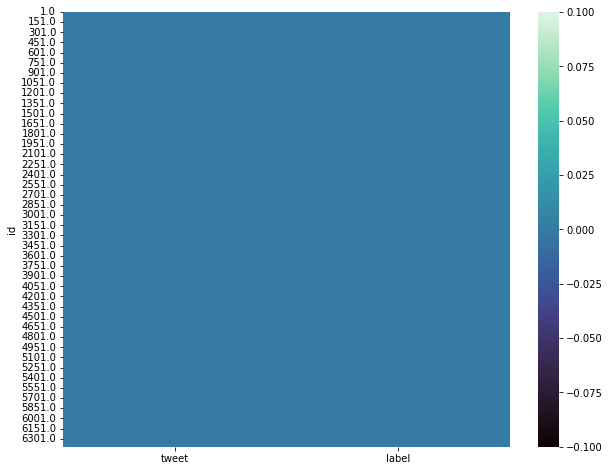

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(train.isnull(),cmap='mako')

## Tweets (Text) Preprosesing

In [ ]:
### Tweets Preprocesing ###
def CleanText(text):
## Stop words
  stop_words  = set(stopwords.words("english"))
## Stemmer
  lemmatizer = WordNetLemmatizer()
  #stemmer  = PorterStemmer() 
## Text to string
  string=str(text)
## Text to Lower case
  text = string.lower().split()
## Join splits
  text = " ".join(text)
## Resub unessential 
  text = re.sub(r'[^0-9a-zA-Z]+',' ',text)
  text=re.sub(r'#\w*', '', text)
  text=re.sub(r'(?<![\w\-])\w(?![\w\-])', '', text)
  text=re.sub(r'\s+[a-zA-Z]\s+', '', text)
  text=re.sub(r'(RT|rt|FAV|fav|VIA|via)', '', text)
  text=re.sub(r'(RT|rt|FAV|fav|VIA|via)', '', text)
  text = re.sub(r"http(\S)+",' ',text)    
  text = re.sub(r"www(\S)+",' ',text)
  text=re.sub(r'@\w*', '', text)
  text = re.sub(r"&",' and ',text) 
  try:
    text=re.sub(r'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])', '', text)
  except re.error:
    text=re.sub(r'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])', '', text)
  token= nltk.word_tokenize(text)     
  token = [w for w in token if not w in stop_words]
  #text = ' '.join([stemmer.stem(w) for w in token])
  text = ' '.join([lemmatizer.lemmatize(w) for w in token])    
  return text

In [ ]:
## Apply CleanText for each tweet
train['tweet'] = train['tweet'].map(lambda x: CleanText(x))
val['tweet'] = val['tweet'].map(lambda x: CleanText(x))
test['tweet'] = test['tweet'].map(lambda x: CleanText(x))
test_withlabel['tweet'] = test_withlabel['tweet'].map(lambda x: CleanText(x))

## ED on train

In [ ]:
train.head()

,tweet,label
id,,
1.0,cdc currently repos 99031 death general discre...,real
2.0,state repoed 1121 death small rise last tuesda...,real
3.0,politically correct woman almost us pandemic e...,fake
4.0,indiafightscorona 1524 covid testing laborator...,real
5.0,populous state generate large case count look ...,real


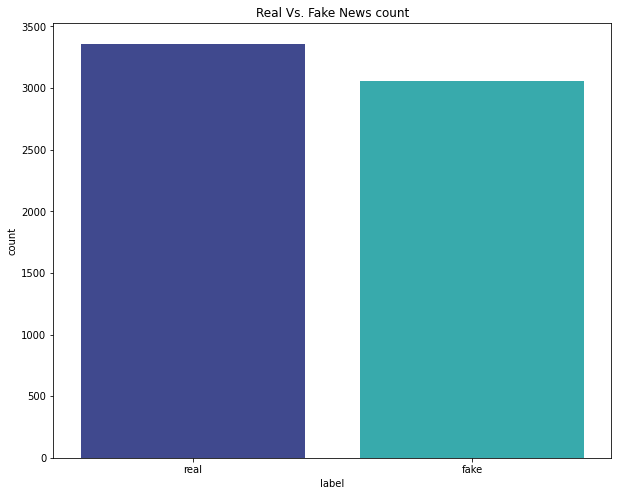

In [ ]:
plt.figure(figsize = (10,8))
sns.countplot(x='label', data = train, palette = 'mako',saturation = 1)
plt.title("Real Vs. Fake News count", fontsize = 12)
plt.show()

### Unigram

Text(0.5, 0, 'No: of Occurances')

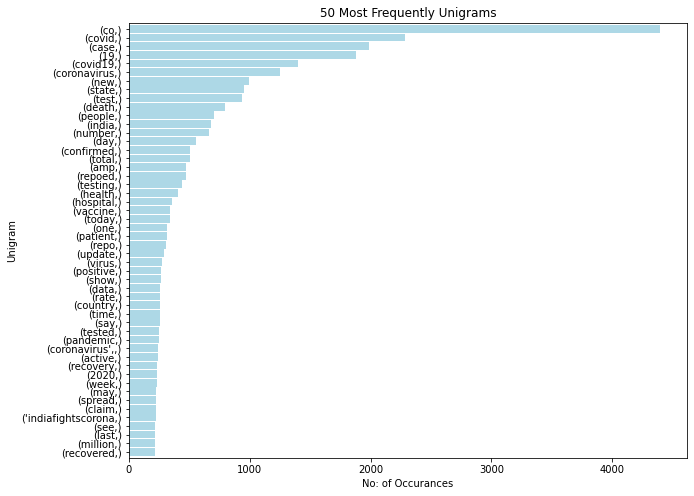

In [ ]:
## unigram
texts = ''.join(str(train['tweet'].tolist()))
tokenized = texts.split()
unigram = (pd.Series(nltk.ngrams(tokenized, 1)).value_counts())[:50]
unigram.sort_values().plot.barh(width=.9,color='lightblue',figsize=(10, 8))
plt.title('50 Most Frequently Unigrams')
plt.ylabel('Unigram')
plt.xlabel('No: of Occurances')

In [ ]:
## Total number of words
train['words'] = train['tweet'].apply(lambda x: len(x.split()))
## Total number of words(unique)
train['unique_words'] = train['tweet'].apply(lambda x: len(set(x.split())))
## Total number of words(characters)
train['char'] = train['tweet'].apply(lambda x: len(x))



In [ ]:
train.head()

,tweet,label,words,unique_words,char
id,,,,,
1.0,cdc currently repos 99031 death general discre...,real,20,18,142
2.0,state repoed 1121 death small rise last tuesda...,real,15,12,91
3.0,politically correct woman almost us pandemic e...,fake,14,14,105
4.0,indiafightscorona 1524 covid testing laborator...,real,19,19,151
5.0,populous state generate large case count look ...,real,31,26,167


In [ ]:
## WordCloud
texts_real = " ".join(train[train['label']=='real']['tweet'])
texts_fake = " ".join(train[train['label']=='fake']['tweet'])

### Word Cloud

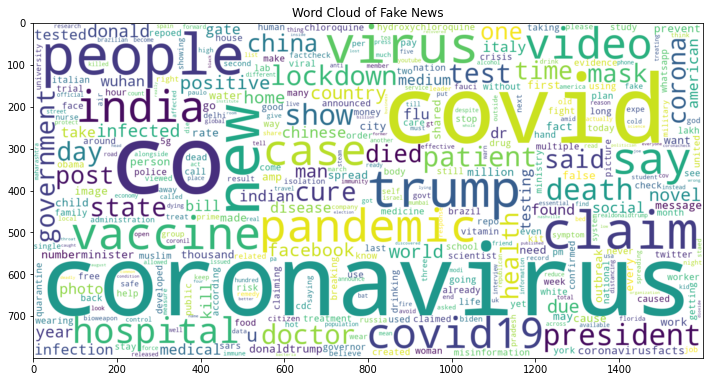

In [ ]:
plt.figure(figsize=(12,8))
wcfake = WordCloud(max_words = 400 , width = 1600, height = 800,background_color="white",collocations=False).generate(texts_fake)
plt.title("Word Cloud of Fake News")
plt.imshow(wcfake , interpolation = 'bilinear')

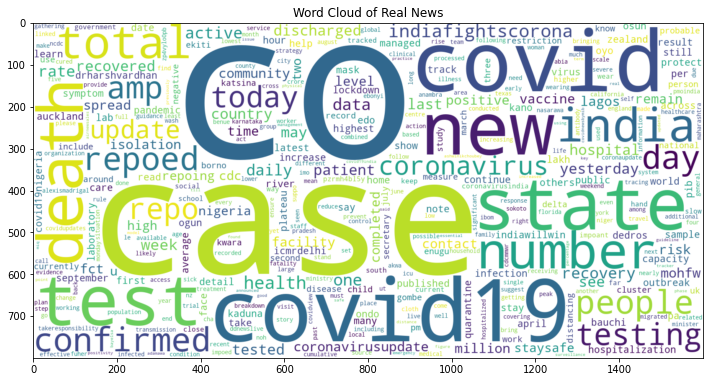

In [ ]:
plt.figure(figsize=(12,8))
wcreal = WordCloud(max_words = 400 , width = 1600, height = 800,background_color="white",collocations=False).generate(texts_real)
plt.title("Word Cloud of Real News")
plt.imshow(wcreal , interpolation = 'bilinear')

## Model Development

In [ ]:
x_train=train['tweet']
y_train=train['label']
x_val=val['tweet']
y_val=val['label']
x_test=test['tweet']
#y_test=test['label']
x_test_withlabel=test_withlabel['tweet']
y_test_withlabel=test_withlabel['label']

In [ ]:
## Vector of Data
countvector = CountVectorizer(lowercase=False)
train_data = countvector.fit_transform(x_train) 
val_data = countvector.transform(x_val)
test_data = countvector.transform(x_test_withlabel) 

### SVM

SVM Accuracy(test):  0.9317757009345794
SVM Precision(test):  0.9318028940548182
SVM Recal(test):  0.9317757009345794
SVM F1_score(test):  0.9317599425949001


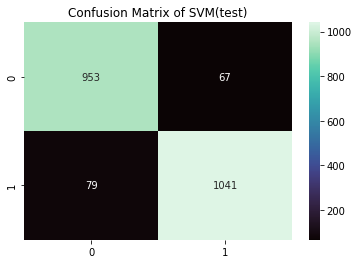

In [ ]:
## test
svm=LinearSVC(random_state=0, tol=1e-5)
svm.fit(train_data,y_train)
svm_pred=svm.predict(test_data)
svm_acc = accuracy_score(svm_pred,y_test_withlabel)
svm_prec=precision_score(svm_pred,y_test_withlabel, average = 'weighted')
svm_rec=recall_score(svm_pred,y_test_withlabel,  average = 'weighted')
svm_f1=f1_score(svm_pred,y_test_withlabel,  average = 'weighted')
print("SVM Accuracy(test): ",svm_acc)
print("SVM Precision(test): ",svm_prec)
print("SVM Recal(test): ",svm_rec)
print("SVM F1_score(test): ",svm_f1)
svm_matrixt=confusion_matrix(y_test_withlabel,svm_pred)
plt.title("Confusion Matrix of SVM(test)")
sns.heatmap(svm_matrixt, annot=True, fmt='', cmap='mako')

### Gradient Boost

Gradient Boost Accuracy(test):  0.8906542056074767
Gradient Boost Precision(test):  0.8906463847221131
Gradient Boost Recal(test):  0.8906542056074767
Gradient Boost F1_score(test):  0.8906495159369164


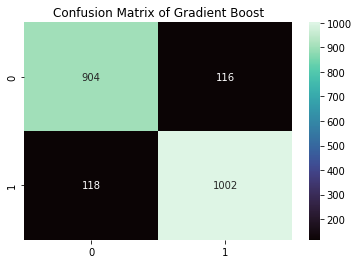

In [ ]:
## test
gb=GradientBoostingClassifier(random_state=0)
gb.fit(train_data,y_train)
gb_pred=gb.predict(test_data)
gb_acc = accuracy_score(gb_pred,y_test_withlabel)
gb_prec=precision_score(gb_pred,y_test_withlabel, average = 'weighted')
gb_rec=recall_score(gb_pred,y_test_withlabel,  average = 'weighted')
gb_f1=f1_score(gb_pred,y_test_withlabel,  average = 'weighted')
print("Gradient Boost Accuracy(test): ",gb_acc)
print("Gradient Boost Precision(test): ",gb_prec)
print("Gradient Boost Recal(test): ",gb_rec)
print("Gradient Boost F1_score(test): ",gb_f1)
gb_matrix=confusion_matrix(y_test_withlabel,gb_pred)
plt.title("Confusion Matrix of Gradient Boost")
sns.heatmap(gb_matrix, annot=True, fmt='', cmap='mako')

### Logistic Regression

Logistic Regression Accuracy(test):  0.9200934579439253
Logistic Regression Precision(test):  0.9203180956962224
Logistic Regression Recal(test):  0.9200934579439253
Logistic Regression F1_score(test):  0.9200590271473257


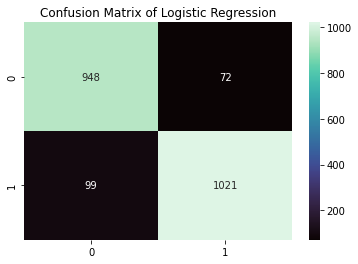

In [ ]:
## test
lg=LogisticRegression(random_state=0,C=0.1)
lg.fit(train_data,y_train)
lg_pred=lg.predict(test_data)
lg_acc = accuracy_score(lg_pred,y_test_withlabel)
lg_prec=precision_score(lg_pred,y_test_withlabel, average = 'weighted')
lg_rec=recall_score(lg_pred,y_test_withlabel,  average = 'weighted')
lg_f1=f1_score(lg_pred,y_test_withlabel,  average = 'weighted')
print("Logistic Regression Accuracy(test): ",lg_acc)
print("Logistic Regression Precision(test): ",lg_prec)
print("Logistic Regression Recal(test): ",lg_rec)
print("Logistic Regression F1_score(test): ",lg_f1)
lg_matrix=confusion_matrix(y_test_withlabel,lg_pred)
plt.title("Confusion Matrix of Logistic Regression")
sns.heatmap(lg_matrix, annot=True, fmt='', cmap='mako')

### Decision Tree

Decision Tree Accuracy(test):  0.8864485981308411
Decision Tree Precision(test):  0.8866216229482448
Decision Tree Recal(test):  0.8864485981308411
Decision Tree F1_score(test):  0.8864914934620883


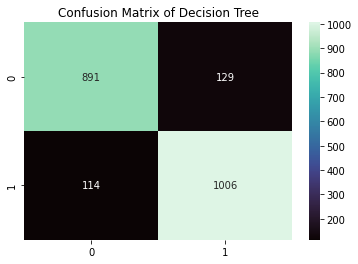

In [ ]:
## test
dt=tree.DecisionTreeClassifier(random_state=0)
dt.fit(train_data,y_train)
dt_pred=dt.predict(test_data)
dt_acc = accuracy_score(dt_pred,y_test_withlabel)
dt_prec=precision_score(dt_pred,y_test_withlabel, average = 'weighted')
dt_rec=recall_score(dt_pred,y_test_withlabel,  average = 'weighted')
dt_f1=f1_score(dt_pred,y_test_withlabel,  average = 'weighted')
print("Decision Tree Accuracy(test): ",dt_acc)
print("Decision Tree Precision(test): ",dt_prec)
print("Decision Tree Recal(test): ",dt_rec)
print("Decision Tree F1_score(test): ",dt_f1)
dt_matrix=confusion_matrix(y_test_withlabel,dt_pred)
plt.title("Confusion Matrix of Decision Tree")
sns.heatmap(dt_matrix, annot=True, fmt='', cmap='mako')

In [ ]:
# initialize list of lists
models= [['Decision Tree',dt_acc,dt_prec,dt_rec,dt_f1],['Logistic Regression',lg_acc,lg_prec,lg_rec,lg_f1],['SVM',svm_acc,svm_prec,svm_rec,svm_f1],['Gradient Boost',gb_acc,gb_prec,gb_rec,gb_f1]]
  
# Create the pandas DataFrame
dfmodels= pd.DataFrame(models, columns=['Algorithm Name', 'Accuracy','Precision','Recal','F1_score'])
  
# print dataframe.
dfmodels

,Algorithm Name,Accuracy,Precision,Recal,F1_score
0,Decision Tree,0.886449,0.886622,0.886449,0.886491
1,Logistic Regression,0.920093,0.920318,0.920093,0.920059
2,SVM,0.931776,0.931803,0.931776,0.931760
3,Gradient Boost,0.890654,0.890646,0.890654,0.890650
